In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline
%load_ext autotime

time: 0 ns (started: 2021-06-08 15:15:02 +09:00)


In [2]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

time: 360 ms (started: 2021-06-08 15:15:02 +09:00)


In [3]:
print("train set : {}개".format(train_data.shape[0]))
print("test set : {}개".format(test_data.shape[0]))

train set : 150000개
test set : 50000개
time: 0 ns (started: 2021-06-08 15:15:03 +09:00)


In [4]:
# 학습 데이터 셋 데이터 탐색
train_data['document'].nunique(), train_data['label'].nunique()
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
print('중복 제거 후 총 샘플의 수 :',len(train_data))

중복 제거 후 총 샘플의 수 : 146183
time: 125 ms (started: 2021-06-08 15:15:03 +09:00)


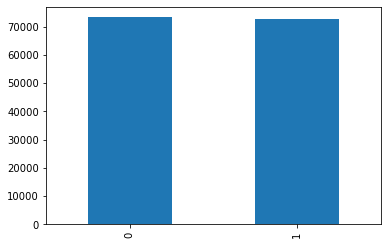

time: 109 ms (started: 2021-06-08 15:15:03 +09:00)


In [5]:
train_data['label'].value_counts().plot(kind = 'bar')
plt.show()

In [12]:
train_data.drop_duplicates(subset = ['document'], inplace=True)
train_data['document'] = train_data['document'].str.replace(pat=r'[^\w]', repl=r'', regex=True)
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['document'] = train_data['document'].str.replace("[.,;:|\)*~`!@#$?%^&*=+-_)>]","")
train_data['document'] = train_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
train_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
train_data = train_data.dropna(how='any') # Null 값 제거
print('전처리 후 훈련용 샘플의 개수 :',len(train_data))

<ipython-input-12-b031948178d0>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-12-b031948178d0>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[.,;:|\)*~`!@#$?%^&*=+-_)>]","")
<ipython-input-12-b031948178d0>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


전처리 후 훈련용 샘플의 개수 : 142878
time: 484 ms (started: 2021-06-08 15:16:27 +09:00)


In [13]:
# 테스트 데이터도 수행
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace(pat=r'[^\w]', repl=r'', regex=True) # 특수문자 제외
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48210
time: 125 ms (started: 2021-06-08 15:16:28 +09:00)


<ipython-input-13-885301132f8e>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-13-885301132f8e>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [16]:
# 형태소 단위로 쪼갠 뒤 각 품사들을 태깅해서 리스트 형태로 반환해줌 
okt = Okt()

pos_lst = []

for pos in test_data['document']:
    pos_lst.extend(okt.pos(pos))

print(pos_lst)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
twitter = Okt()
def tw_tokenizer_nouns(text):
    tokens_ko = twitter.nouns(text)
    return tokens_ko

nouns = []
for i in range(0,len(train_df['document'])):
    nouns.extend(tw_tokenizer_nouns(train_df['document'][i]))